# Unsupervised ML - Netflix Movies and TV Shows Clustering

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk.tokenize import TweetTokenizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Dataset Loading
df = pd.read_csv("C:/Users/Anurag/Downloads/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")

In [3]:
# Dataset View
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
# Rows and Column Count
df.shape

(7787, 12)

In [5]:
#Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [6]:
# Check Duplicate
df.duplicated().sum()

0

In [7]:
# Count of unique values in each column
for i in df.columns:
    print("The unique value of ",i,"is",df[i].unique().size)

The unique value of  show_id is 7787
The unique value of  type is 2
The unique value of  title is 7787
The unique value of  director is 4050
The unique value of  cast is 6832
The unique value of  country is 682
The unique value of  date_added is 1566
The unique value of  release_year is 73
The unique value of  rating is 15
The unique value of  duration is 216
The unique value of  listed_in is 492
The unique value of  description is 7769


In [8]:
# Check Null Values
df.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [9]:
# Handlnig Missing Values

df[['director','cast','country']] = df[['director','cast','country']].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.dropna(axis=0,inplace=True)

In [10]:
# Top Countries
df.country.value_counts()

country
United States                                                   2549
India                                                            923
Unknown                                                          506
United Kingdom                                                   396
Japan                                                            225
                                                                ... 
Russia, United States, China                                       1
Italy, Switzerland, France, Germany                                1
United States, United Kingdom, Canada                              1
United States, United Kingdom, Japan                               1
Sweden, Czech Republic, United Kingdom, Denmark, Netherlands       1
Name: count, Length: 682, dtype: int64

In [11]:
# Top Genres
df.listed_in.value_counts()

listed_in
Documentaries                                                                      334
Stand-Up Comedy                                                                    321
Dramas, International Movies                                                       320
Comedies, Dramas, International Movies                                             243
Dramas, Independent Movies, International Movies                                   215
                                                                                  ... 
Anime Series, Crime TV Shows, TV Thrillers                                           1
Crime TV Shows, Romantic TV Shows, Spanish-Language TV Shows                         1
Crime TV Shows, International TV Shows, Reality TV                                   1
International Movies, Romantic Movies, Sci-Fi & Fantasy                              1
International TV Shows, Spanish-Language TV Shows, Stand-Up Comedy & Talk Shows      1
Name: count, Length: 491, dtype: 

In [12]:
# Choosing Primary Country and Primary Genre to simplify analysis
df['country'] = df['country'].apply(lambda x:x.split(',')[0])
df['listed_in'] = df['listed_in'].apply(lambda x:x.split(',')[0])

In [13]:
# Splitting the duration column, and changing the datatype to integer
df['duration'] = df['duration'].apply(lambda x: int(x.split()[0]))

In [14]:
# Number of Season for TV Shows
df[df['type'] == 'TV Show'].duration.value_counts()

duration
1     1608
2      378
3      183
4       86
5       57
6       30
7       19
8       18
9        8
10       5
11       2
12       2
15       2
13       1
16       1
Name: count, dtype: int64

In [15]:
# Movie Length in Minutes

df[df['type'] == 'Movie'].duration.unique()

array([ 93,  78,  80, 123,  95, 119, 118, 143, 103,  89,  91, 149, 144,
       124,  87, 110, 128, 117, 100,  84,  99,  90, 102, 104, 105,  56,
       125,  81,  97, 106, 107, 109,  44,  75, 101,  37, 113, 114, 130,
        94, 140, 135,  82,  70, 121,  92, 164,  53,  83, 116,  86, 120,
        96, 126, 129,  77, 137, 148,  28, 122, 176,  85,  22,  68, 111,
        29, 142, 168,  21,  59,  20,  98, 108,  76,  26, 156,  30,  57,
       150, 133, 115, 154, 127, 146, 136,  88, 131,  24, 112,  74,  63,
        38,  25, 174,  60, 153, 158, 151, 162,  54,  51,  69,  64, 147,
        42,  79,  40,  45, 172,  10, 163,  55,  72,  61,  71, 160, 171,
        48, 139, 157,  15,  65, 134, 161,  62, 186,  49,  73,  58, 165,
       166, 138, 159, 141, 132,  52,  67,  34,  66, 312, 180,  47, 155,
        14, 177,  11,   9,  46, 145,   8,  12,  43,  50,  23, 185, 200,
       169,  27, 170, 196,  33, 181, 204,  32,  35, 167, 179, 193,  13,
       214,  17, 173, 192, 209, 187,  41, 182, 224, 233, 189, 15

In [16]:
# Datatype Duration
df.duration.dtype

dtype('int64')

In [17]:
# Typecasting date_added from string to datetime
df['date_added'] = pd.to_datetime(df['date_added'],format='mixed')

In [18]:
# Adding new attributes month and year of date_added
df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year

<Axes: xlabel='rating', ylabel='count'>

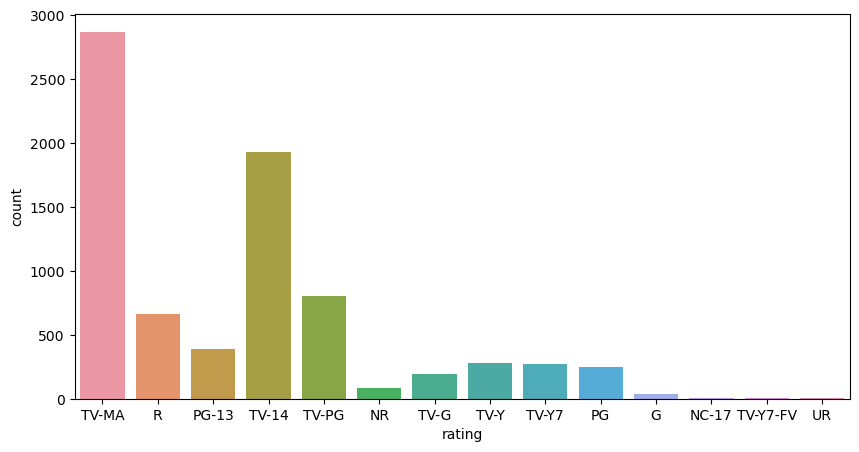

In [19]:
# Ratings for shows in dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

Text(0.5, 1.0, 'Total Movies and TV Shows')

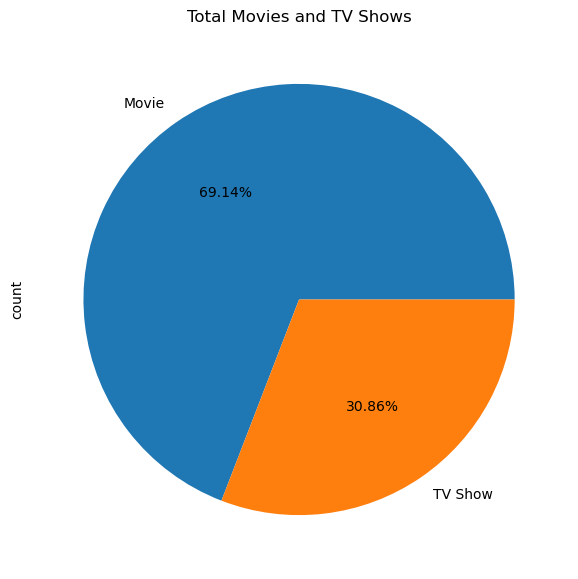

In [20]:
# Number of movies and Tv Shows in dataset
plt.figure(figsize=(7,7))
df.type.value_counts().plot(kind='pie', autopct = '%1.2f%%')
plt.title('Total Movies and TV Shows')
              

<Axes: ylabel='country'>

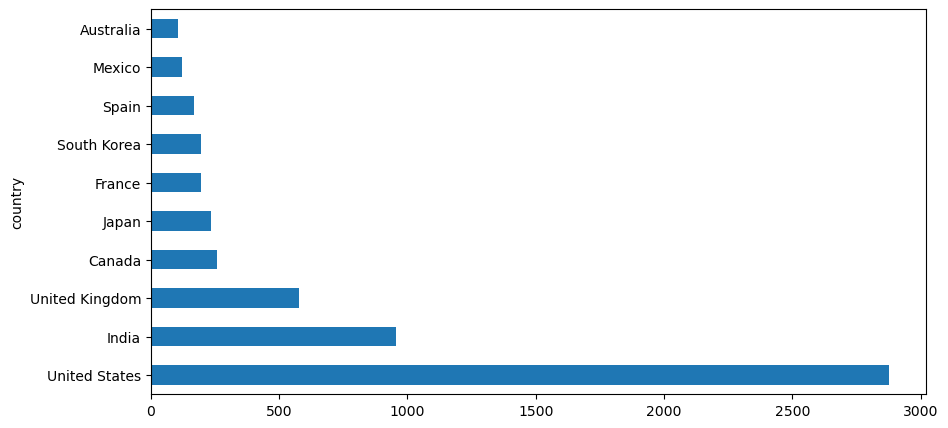

In [21]:
# Top 10 countries with highest number of movies/tv shows 
plt.figure(figsize=(10,5))
df[~(df['country']=='Unknown')].country.value_counts().nlargest(10).plot(kind='barh')

D:\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Movie/ TV Show release year distribution')

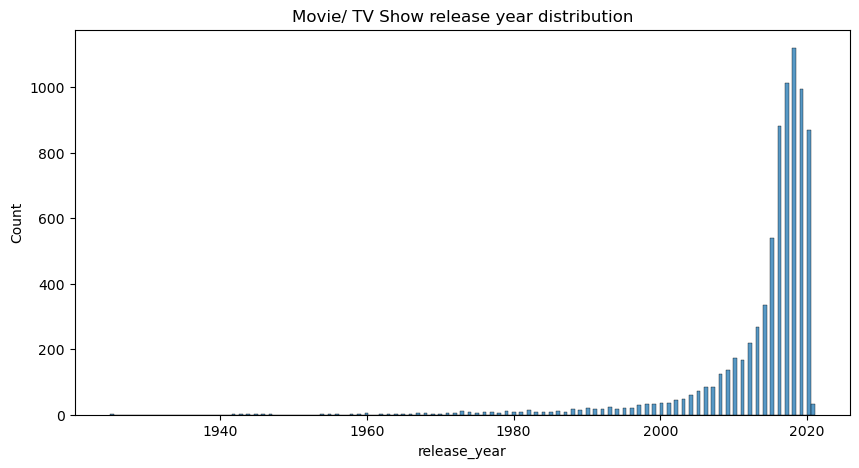

In [22]:
# Visualizing the year in which movie/tv show released
plt.figure(figsize=(10,5))
sns.histplot(df['release_year'])
plt.title('Movie/ TV Show release year distribution')

Text(0.5, 1.0, 'Top 10 Genres')

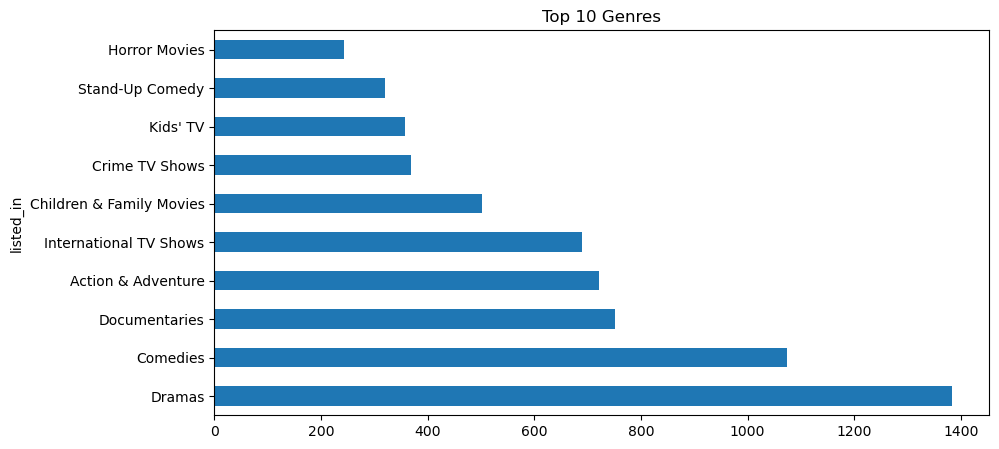

In [23]:
#Top 10 Genre
plt.figure(figsize=(10,5))
df.listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 Genres')

Text(0.5, 1.0, 'Number of shows on Netflix for diffetrent age groups')

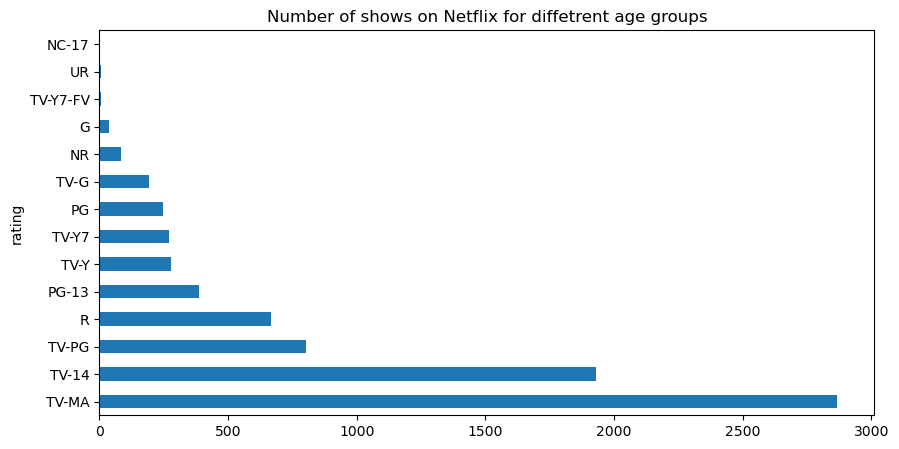

In [24]:
# Number of shows on Netflix for diffetrent age groups
plt.figure(figsize=(10,5))
df.rating.value_counts().plot(kind='barh')
plt.title("Number of shows on Netflix for diffetrent age groups")

<Axes: xlabel='year_added', ylabel='count'>

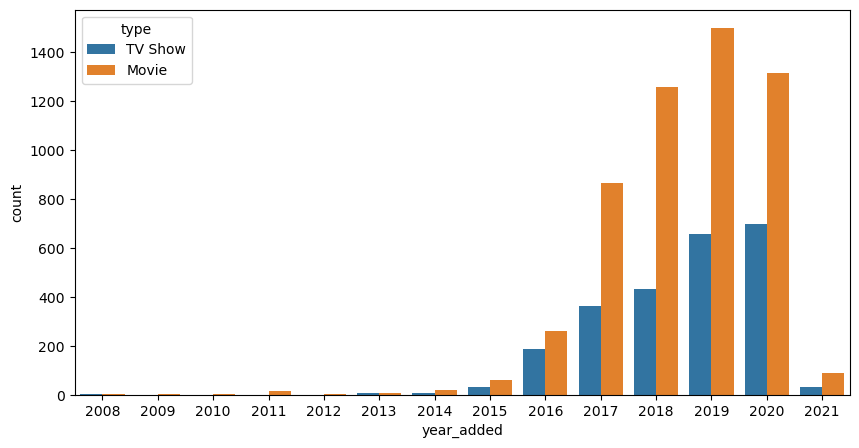

In [25]:
# Number of movies and shows added over the years
plt.figure(figsize=(10,5))
sns.countplot(x='year_added',data=df,hue='type')

D:\Python\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Movie Duration Distribution ')

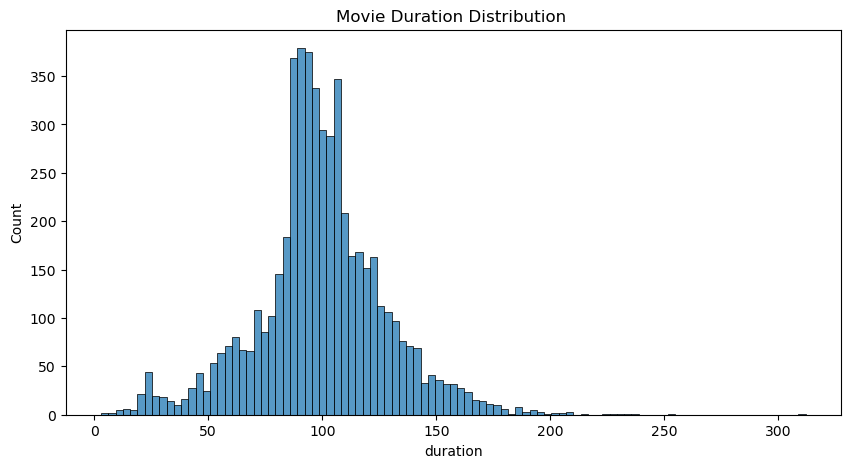

In [26]:
# Length of movie analysis
plt.figure(figsize=(10,5))
sns.histplot(x='duration',data=df[df['type']=='Movie'])
plt.title('Movie Duration Distribution ')

Text(0, 0.5, 'Length of movie in minutes')

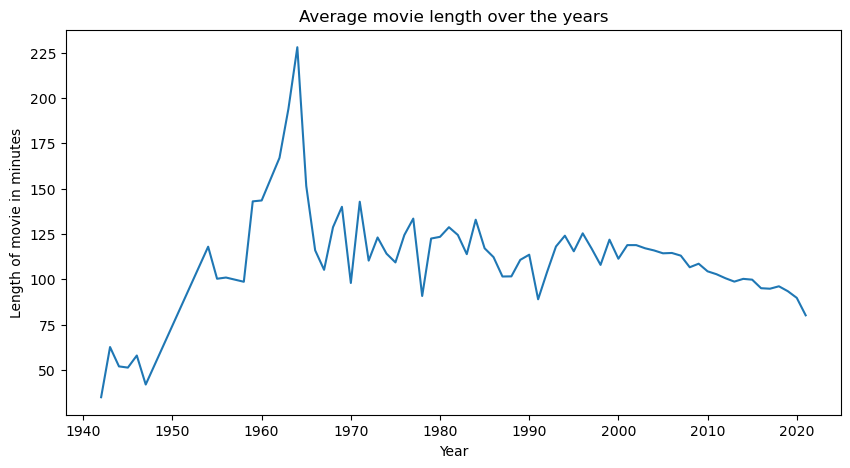

In [27]:
# Average Movie Length per year
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].groupby('release_year')['duration'].mean().plot(kind='line')
plt.title('Average movie length over the years')
plt.xlabel('Year')
plt.ylabel('Length of movie in minutes')

Text(0.5, 1.0, 'Top 10 genres for movies')

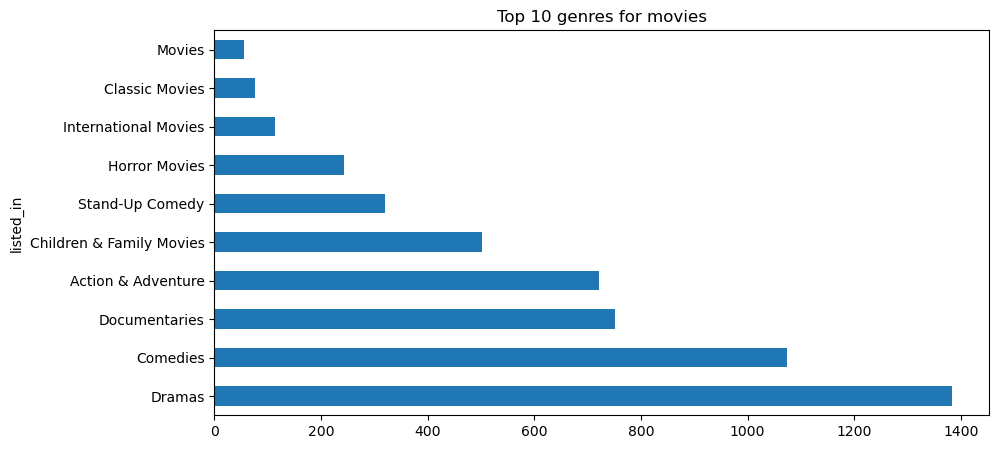

In [28]:
# Top 10 Genre of Movies
plt.figure(figsize=(10,5))
df[df['type']=='Movie'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for movies')

Text(0.5, 1.0, 'Top 10 genres for TV Show')

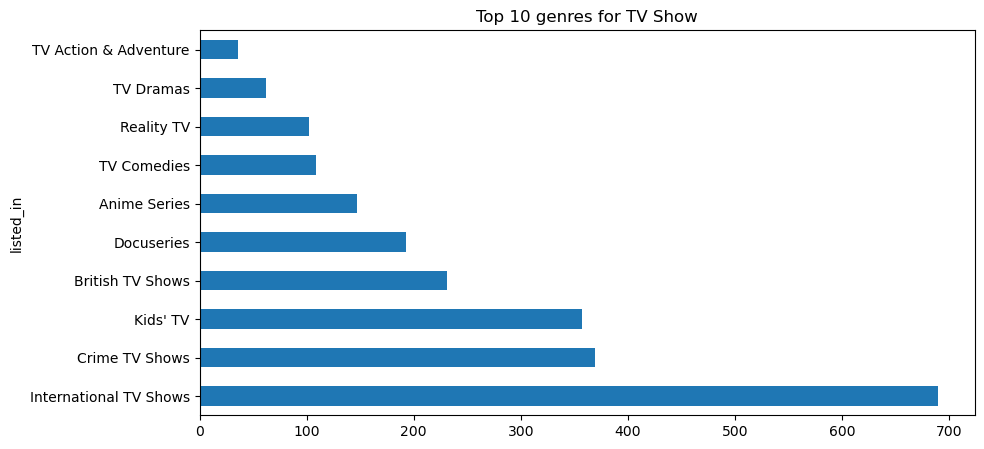

In [29]:
# Top 10 Genre of TV Show
plt.figure(figsize=(10,5))
df[df['type']=='TV Show'].listed_in.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for TV Show')

Text(0.5, 1.0, 'Top 10 Movie Actors')

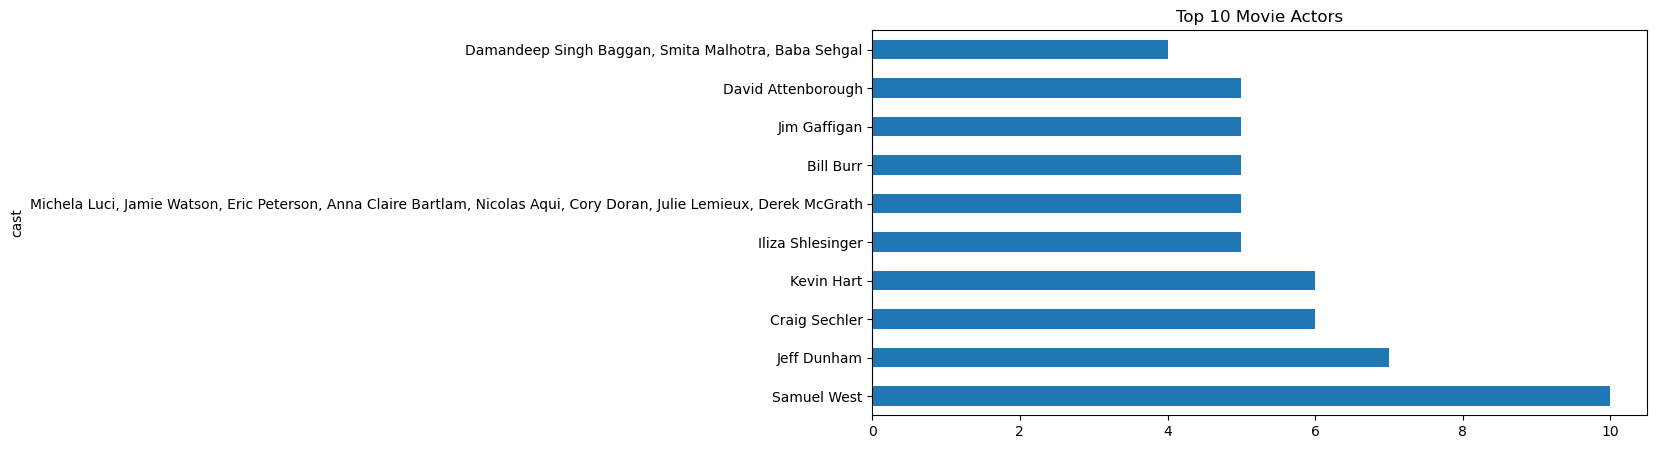

In [30]:
# Top actors for movies
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='Movie')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 Movie Actors')

Text(0.5, 1.0, 'Top 10 TV Show Actors')

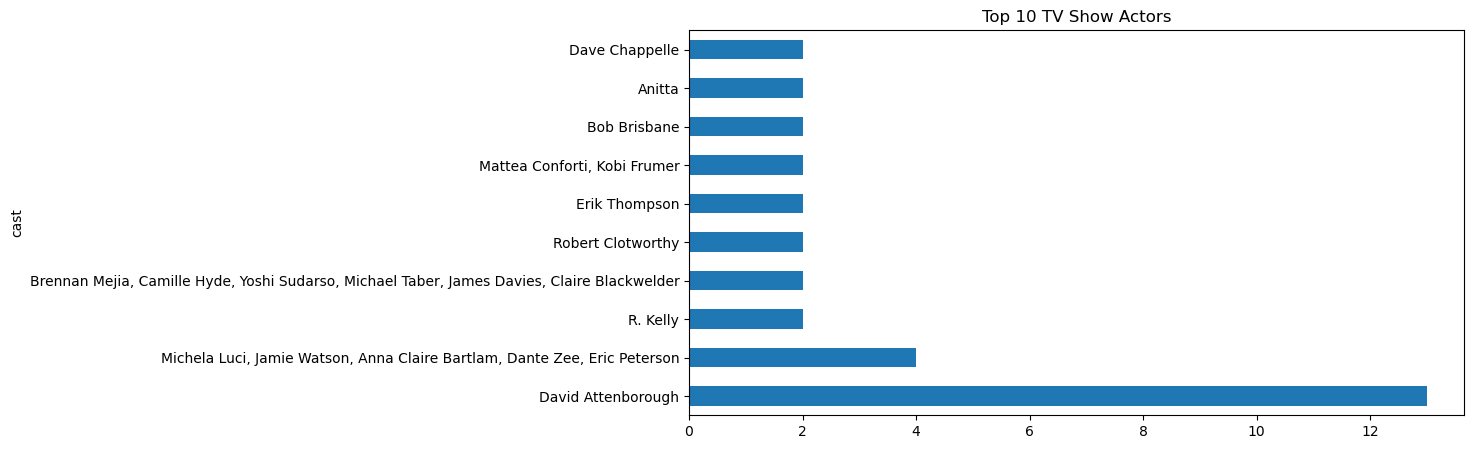

In [31]:
# Top actors for TV Shows
plt.figure(figsize=(10,5))
df[~(df['cast']=='Unknown') & (df['type']=='TV Show')].cast.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 TV Show Actors')

In [32]:
df1 = df.copy()
df1.fillna('',inplace=True)

In [33]:
# Combining all clustering attributes in a single column
df1['clustering_attributes'] = (df1.director + ' ' + 
                                df1.cast + ' ' +df1.country + ' ' +
                                df1.listed_in + ' ' + df1.description)
df1.clustering_attributes[40]

'Muharrem Gülmez Erdem Yener, Ayhan Taş, Emin Olcay, Muharrem Gülmez, Elif Nur Kerkük, Tarık Papuççuoğlu, Suzan Aksoy, Doğa Konakoğlu, Esin Eden, Deniz Özerman Turkey Comedies The slacker owner of a public bath house rallies his community to save it when a big developer comes to town to close it down and open a new mall.'

In [34]:
# Removing non-ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD',word).encode('ascii','ignore').decode('utf-8','ignore')
        new_words.append(new_word)
    return new_words

In [35]:
df1.clustering_attributes = remove_non_ascii(df1['clustering_attributes'])
df1.clustering_attributes

0       Unknown Joao Miguel, Bianca Comparato, Michel ...
1       Jorge Michel Grau Demian Bichir, Hector Bonill...
2       Gilbert Chan Tedd Chan, Stella Chung, Henley H...
3       Shane Acker Elijah Wood, John C. Reilly, Jenni...
4       Robert Luketic Jim Sturgess, Kevin Spacey, Kat...
                              ...                        
7782    Josef Fares Imad Creidi, Antoinette Turk, Elia...
7783    Mozez Singh Vicky Kaushal, Sarah-Jane Dias, Ra...
7784    Unknown Nasty C Unknown Documentaries In this ...
7785    Unknown Adriano Zumbo, Rachel Khoo Australia I...
7786    Sam Dunn Unknown United Kingdom Documentaries ...
Name: clustering_attributes, Length: 7777, dtype: object

In [36]:
# Extracting Stop words
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [37]:
# Function to remove stopwords
def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    return " ".join(text)

In [38]:
# Removing stop words
df1.clustering_attributes = df1['clustering_attributes'].apply(stopwords)

In [39]:
# Remove Punctuation
def remove_punctuation(text):
    translator = str.maketrans('','',string.punctuation)
    return text.translate(translator)

In [40]:
df1.clustering_attributes = df1.clustering_attributes.apply(remove_punctuation)

In [41]:
# Tokenization
tokenizer = TweetTokenizer()
df1.clustering_attributes = df1.clustering_attributes.apply(lambda x:tokenizer.tokenize(x))

In [42]:
# Vectorization
clustering_data = df1['clustering_attributes']

In [43]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer,stop_words='english',lowercase=False,max_features=20000)
X = tfidf.fit_transform(clustering_data)

D:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [44]:
X

<7777x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 222409 stored elements in Compressed Sparse Row format>

In [45]:
X.shape

(7777, 20000)

In [46]:
# Convert X into array form
X = X.toarray()

In [47]:
# Dimension reduction using PCA
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'cumulative expalined variance')

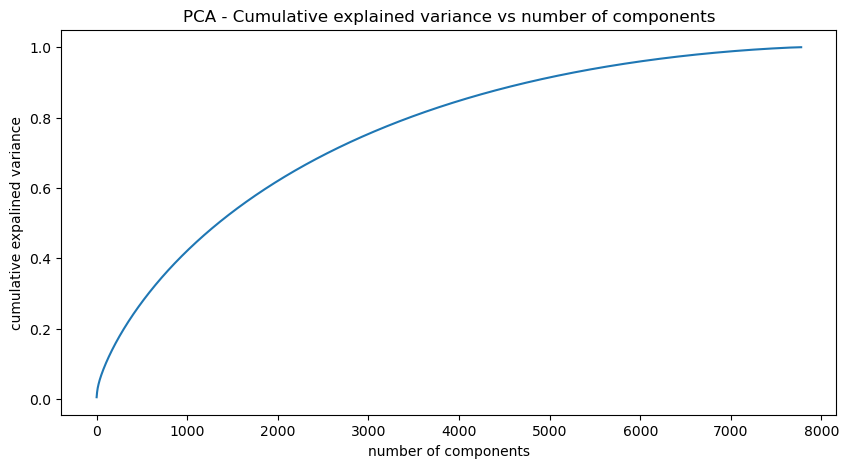

In [48]:
# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative expalined variance')

In [49]:
# reducing the dimensions to 4000 using pca
pca = PCA(n_components = 4000, random_state=42)
pca.fit(X)

PCA(n_components=4000, random_state=42)

In [50]:
 #transformed features
x_pca = pca.transform(X)

In [51]:
#shape of transformed vectors
x_pca.shape

(7777, 4000)

D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change

Text(0, 0.5, 'WCSS')

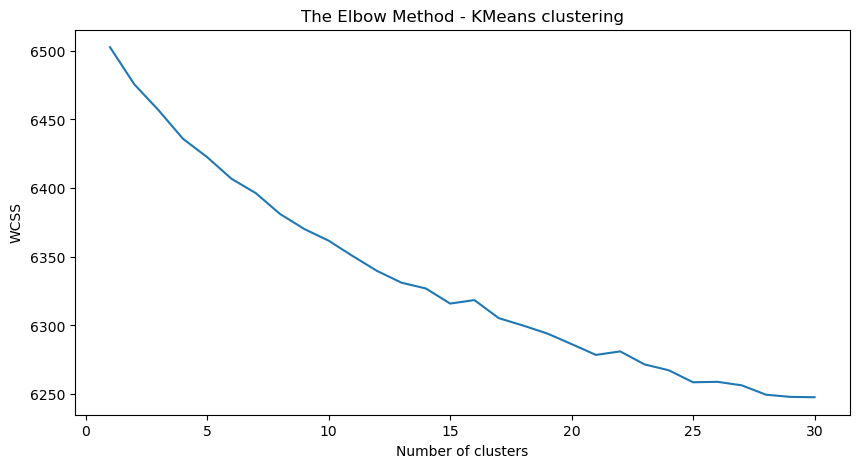

In [52]:
# Clustering Implementation, find optimal numner of clusters
wcss = []
for i in range(1,31):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
    kmeans.fit(x_pca)
    wcss_iter=kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change

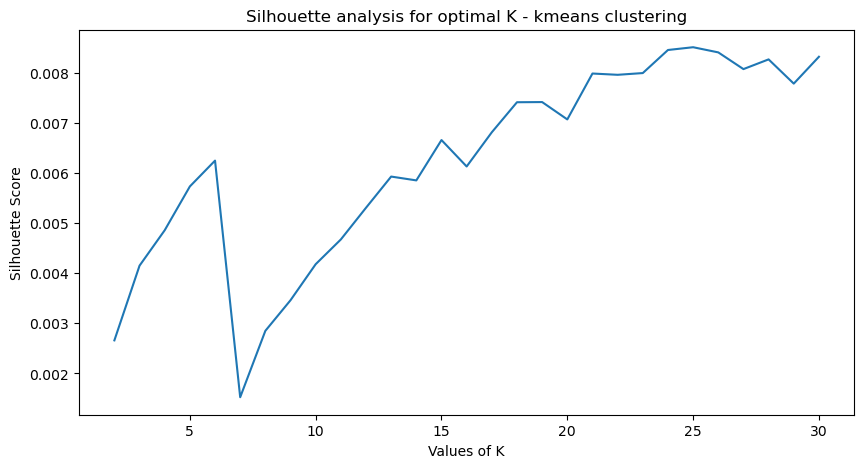

In [53]:
# Plotting Silhouette score for different number of clusters
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters, init='k-means++',random_state=33)
    kmeans.fit(x_pca)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(x_pca,cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.title('Silhouette analysis for optimal K - kmeans clustering')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.show()


In [54]:
# Clustering data
kmeans = KMeans(n_clusters=6,init='k-means++',random_state=33)
kmeans.fit(x_pca)

D:\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=33)

In [55]:
#Adding Kmeans cluster attribute
df1['kmeans_cluster'] = kmeans.labels_

Text(0.5, 1.0, 'Number of movies and tv shows in each cluster - Kmeans Clustering')

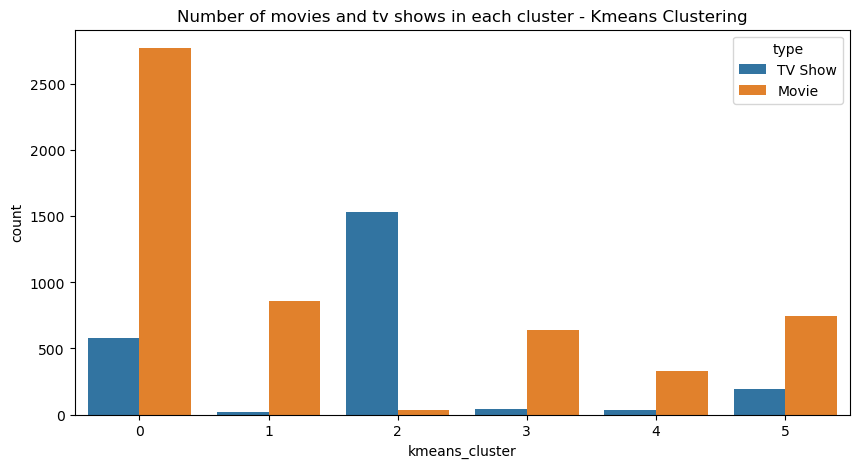

In [57]:
# Number of movies and shows in each cluster
plt.figure(figsize=(10,5))
q=sns.countplot(x='kmeans_cluster',data=df1,hue='type')
plt.title('Number of movies and tv shows in each cluster - Kmeans Clustering')
